# Neural Network using Strassens Algorithm

In [1]:
import tensorflow as tf

/Users/jackweissenberger/anaconda3/envs/fastMM/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import numpy as np
from numpy import linalg as la

In [3]:
batch_size = 100
seed = 18

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [6]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

In [7]:
def strass(A, B, steps):
  
    #Check Dimensions
    # tensor.get_shape().as_list()
    (m, n) = A.get_shape().as_list()
    (nn, p) = B.get_shape().as_list()

    #old code case m, n, nn, and p as ints
    
    if n != nn: raise ValueError("incompatible dimensions")
    C = tf.zeros([m,p])
    
    #Base case
    if steps == 0 or m ==1 or n ==1 or p == 1:
        C = tf.matmul(A,B)
        return C
    
    #Dynamic peeling
    # *****************
    if m % 2 == 1:
        #C[:m-1, :] 
        Cmat= strass(A[:m-1,:],B, steps)
        #C[m-1,:], need to expand the dims b/c tf.matmul doesn't work for 1D vectors 
        Crow = tf.matmul(tf.expand_dims(A[m-1,:],0),B)
        return tf.concat([Cmat, Crow], 0)
    if n % 2 == 1:
        Cmat = strass(A[:, :n-1], B[:n-1,:], steps)
        C = tf.add(Cmat,  tf.matmul(tf.expand_dims(A[:,n-1],1),tf.expand_dims(B[n-1,:],0)))
        return C
    if p % 2 == 1:
        #C[:, :p-1]
        Cmat = strass(A, B[:,:p-1], steps)
        #C[:,p-1]
        Ccol = tf.matmul(A,tf.expand_dims(B[:,p-1],1))
        return tf.concat([Cmat, Ccol], 1)
    
    # divide when m, n and p are all even
    m2 = int(m/2)
    n2 = int(n/2)
    p2 = int(p/2)
    A11 = A[:m2,:n2] 
    A12 = A[:m2,n2:]
    A21 = A[m2:,:n2] 
    A22 = A[m2:,n2:]
    B11 = B[:n2,:p2]   
    B12 = B[:n2,p2:]
    B21 = B[n2:,:p2] 
    B22 = B[n2:,p2:]
    
    # conquer
    M1 = strass(A11, tf.subtract(B12,B22)   ,steps-1)
    M2 = strass(tf.add(A11,A12), B22   ,steps-1)
    M3 = strass(tf.add(A21,A22),B11    ,steps-1)
    M4 = strass(A22    ,tf.subtract(B21,B11),steps-1)
    M5 = strass(tf.add(A11, A22), tf.add(B11, B22),steps-1)
    M6 = strass( tf.subtract(A12,A22), tf.add(B21,B22),steps-1)
    M7 = strass(tf.subtract(A11,A21), tf.add(B11, B12),steps-1)
    
    # conquer    
    #C[:m2,:p2] 
    C11 = tf.add(tf.subtract(tf.add(M5, M4), M2), M6) 
    #C[:m2,p2:]
    C12 = tf.add(M1, M2) 
    #C[m2:,:p2] 
    C21 = tf.add(M3,M4)
    #C[m2:,p2:]
    C22 = tf.subtract(tf.subtract(tf.add(M1,M5), M3), M7)
    
    # nation building
    C1 = tf.concat([C11, C12], 1)
    C2 = tf.concat([C21,C22], 1)
    C = tf.concat([C1,C2], 0)
    
    return C

In [37]:
tf.reset_default_graph()

In [38]:
tf.set_random_seed(seed)

In [39]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 300
n_outputs = 10

In [40]:
# here batch_size was none
X = tf.placeholder(tf.float32, shape=(batch_size, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(batch_size), name="y")

In the cell below I define the layers and their multiplication, typically, I would just use tf.matmul instead of strass, but here I have replaced it

In [41]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        Z = strass(X, W, 2) + b
        
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [42]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [43]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [44]:
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [45]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [46]:
init = tf.global_variables_initializer()
#saver = tf.train.Saver()

In [47]:
n_epochs = 50

In [48]:
with tf.Session() as sess:
    init.run()
    aTrain = []
    aTest = []
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        aTrain.append(acc_train)
        
        num_batches_in_test = mnist.test.num_examples // batch_size
        acc_test = 0
        for j in range(num_batches_in_test):
            acc_test += accuracy.eval(feed_dict={X: mnist.test.images[j*batch_size:batch_size*(j+1)], 
                                                 y: mnist.test.labels[j*batch_size:batch_size*(j+1)]})
        acc_test /= num_batches_in_test
        aTest.append(acc_test)
                                            
        print(epoch, "Train accuracy:", acc_train, "Test accuracy", acc_test)

    #save_path = saver.save(sess, "./my_model_final.ckpt")
    #use the above line if you want to save and reuse the network later on

0 Train accuracy: 0.9 Test accuracy 0.8910000032186508
1 Train accuracy: 0.89 Test accuracy 0.9143000018596649
2 Train accuracy: 0.94 Test accuracy 0.9250000041723251
3 Train accuracy: 0.96 Test accuracy 0.9315000015497208
4 Train accuracy: 0.92 Test accuracy 0.9371000021696091
5 Train accuracy: 0.94 Test accuracy 0.9406000024080277
6 Train accuracy: 0.95 Test accuracy 0.9441000014543534
7 Train accuracy: 0.94 Test accuracy 0.9478000056743622
8 Train accuracy: 0.98 Test accuracy 0.950700004696846
9 Train accuracy: 0.96 Test accuracy 0.9526000058650971
10 Train accuracy: 0.92 Test accuracy 0.9529000073671341
11 Train accuracy: 0.96 Test accuracy 0.9558000069856644
12 Train accuracy: 0.99 Test accuracy 0.956900006532669
13 Train accuracy: 0.99 Test accuracy 0.9588000059127808
14 Train accuracy: 0.98 Test accuracy 0.9598000031709671
15 Train accuracy: 0.99 Test accuracy 0.9614000046253204
16 Train accuracy: 0.98 Test accuracy 0.9618000048398971
17 Train accuracy: 0.98 Test accuracy 0.9617

In [35]:
import matplotlib.pyplot as plt

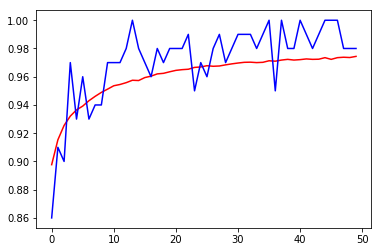

In [22]:
plt.plot(range(n_epochs), aTest, 'r')
plt.plot(range(n_epochs), aTrain, 'b')

0 steps Strass
Epoch 31 to reach 97% test accuracy, final test accuracy .9744

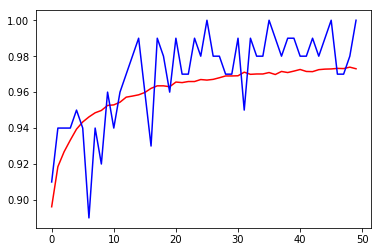

In [36]:
plt.plot(range(n_epochs), aTest, 'r')
plt.plot(range(n_epochs), aTrain, 'b')

1 Step Strassen
epoch 31 reached 97% test accuracy, final test accuracy .9730

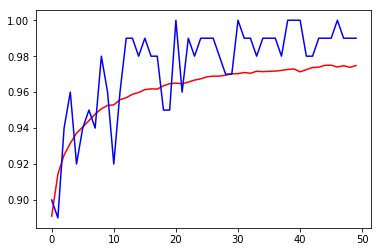

In [49]:
plt.plot(range(n_epochs), aTest, 'r')
plt.plot(range(n_epochs), aTrain, 'b')

2 Step Strassen
epoch 29 reached 97% test accuracy, final test accuracy .9748